<h1><center> Projet KDS - Vendée Globe 2020-2021   </center></h1>

<div style="text-align: center"> 
Alvin SIA - MSBGD - 7/11/2021
</div>

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
from pytz import timezone
from sklearn import linear_model
import datetime
import requests
import multiprocessing
import geopandas
import re
import warnings
warnings.filterwarnings('ignore')

###### Quel est l'état actuel de la course ?
## Téléchargement du dernier classement

In [2]:
path = 'https://www.vendeeglobe.org/fr/classement'
path_dwld = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_'
path_boat = 'https://www.vendeeglobe.org/fr/glossaire'
start = datetime.datetime(2020,11,8,14)
end = datetime.datetime(2021,1,27,14)

In [3]:
def get_soup(url):
    r = requests.get(url)
    return bs(r.content.decode('utf-8'), 'lxml')

In [4]:
def date_to_path(date):
    return path_dwld+date.strftime('%Y%m%d_%H%M%S')+'.xlsx'

In [5]:
def convert_coordinates(s):
    degrees = re.split('[°\']', s)
    return (float(degrees[0]) + (float(degrees[1])/60)) * (-1 if degrees[2] == 'S' or degrees[2] == 'W' else 1)

In [6]:
def normalize_sail(df_voile):
    df_voile = df_voile.fillna('59')
    list_voile = df_voile.unique()
    normalized_list = []
    for voile in list_voile:
        num = int(re.search('\d+',voile).group())
        if num<10: num='0'+str(num)
        pays = re.search('[^\d\s]+',voile)
        if pays: pays = pays.group()
        else : pays = 'FRA'
        normalized_list.append(pays+' '+str(num))
  
    return df_voile.replace(list_voile,normalized_list)

In [7]:
def clean_data(df):
    df = df.drop(columns=[
    'Unnamed: 0',             
    'Cap\nHeading',
    'Vitesse\nSpeed', 
    'VMG\nVMG', 
    'Distance\nDistance',
    'Cap\nHeading.2', 
    'Vitesse\nSpeed.2', 
    'VMG\nVMG.2',
    'Distance\nDistance.2'
    ]).dropna().fillna(' ')

    df.columns = [
    'Rang', 
    'Voile', 
    'Skipper/Bateau', 
    'Heure', 
    'Latitude', 
    'Longitude', 
    'Cap',
    'Vitesse',
    'VMG', 
    'Distance',
    'DTF',
    'DTL']
    
    df['Voile'] = df['Voile'].apply(lambda x: x.split('\n')[1])
    df['Voile'] = normalize_sail(df['Voile'])
    df['Skipper/Bateau'] = df['Skipper/Bateau'].str.replace('\n', ' / ')
    df['Latitude'] = df['Latitude'].apply(convert_coordinates)
    df['Longitude'] = df['Longitude'].apply(convert_coordinates)
    df['Rang'] = df['Rang'].astype(int)

    df['Cap'] = df['Cap'].astype(str).str[:-1]
    for col in ['Heure', 'Vitesse', 'VMG', 'Distance', 'DTF', 'DTL']:
        df[col] = df[col].apply(lambda x: x.split(' ')[0]).astype(int, errors='ignore')

    for col in ['Cap', 'Vitesse', 'VMG', 'Distance', 'DTF', 'DTL']:
        df[col] = df[col].astype(float)
  
    return df

In [8]:
def get_data(date):
    path = date_to_path(date)
    df = pd.read_excel(path, skiprows=2, skipfooter=4, header=2)
    df = clean_data(df)
    df['date'] = date
    return df

df_end = get_data(end)
df_end.head()

,Rang,Voile,Skipper/Bateau,Heure,Latitude,Longitude,Cap,Vitesse,VMG,Distance,DTF,DTL,date
0,1,FRA 79,Charlie Dalin / APIVIA,14:30,46.234500,-3.693500,37.0,19.1,17.4,57.2,80.5,0.0,2021-01-27 14:00:00
1,2,FRA 18,Louis Burton / Bureau Vallée 2,14:31,46.410333,-5.198333,110.0,17.7,16.9,53.3,141.5,60.9,2021-01-27 14:00:00
2,3,MON 10,Boris Herrmann / Seaexplorer - Yacht Club De M...,14:30,44.524333,-5.342500,113.0,16.6,10.3,49.9,190.0,109.5,2021-01-27 14:00:00
3,4,FRA 59,Thomas Ruyant / LinkedOut,14:30,47.407000,-7.368000,102.0,17.6,17.6,52.9,235.8,155.3,2021-01-27 14:00:00
4,5,FRA 17,Yannick Bestaven / Maître Coq IV,14:30,47.723000,-7.980167,98.0,18.1,18.1,54.4,264.3,183.7,2021-01-27 14:00:00


* _DTF_ : Distance To Finish
* _DTL_ : Distance To Leader

### Où sont les voiliers ?

Afin de déterminer la position et la trajectoire des voiliers, on récupère l'historique de tous les classements.

In [9]:
def generate_date_list():
    hours = [4,8,14,17,21]
    date_list=[]
    date = datetime.datetime(start.year,start.month,start.day)
    
    while True:
        for hour in hours:
            date_time = datetime.datetime(date.year,date.month,date.day,hour)
        if date_time<start:
            pass
        elif date_time>end:
            return date_list
        else:
            date_list.append(date_time)
        date += datetime.timedelta(days=1)

In [10]:
def get_data_history():
    df = pd.DataFrame()
    date_list = generate_date_list()

    for date in date_list:
        temp_df = get_data(date)
        df = pd.concat([df, temp_df], ignore_index=True)
  
    return df

In [11]:
hist = get_data_history()
print(hist)

      Rang    Voile                              Skipper/Bateau  Heure  \
0        1   FRA 08                      Jérémie Beyou / Charal  22:30   
1        2   FRA 06          Nicolas Troussel / CORUM L'Épargne  22:30   
2        3   FRA 02       Armel Tripon / L'Occitane en Provence  22:30   
3        4   FRA 59                   Thomas Ruyant / LinkedOut  22:30   
4        5   FRA 79                      Charlie Dalin / APIVIA  22:30   
...    ...      ...                                         ...    ...   
2270    21   FRA 71                Manuel Cousin / Groupe Sétin  21:30   
2271    22   FRA 83  Clément Giraud / Compagnie du lit - Jiliti  21:30   
2272    23   FRA 50         Miranda Merron / Campagne de France  21:30   
2273    24   FRA 72            Alexia Barrier / TSE - 4myplanet  21:30   
2274    25  FIN 222                         Ari Huusela / Stark  21:30   

       Latitude  Longitude    Cap  Vitesse   VMG  Distance      DTF     DTL  \
0     46.212500  -5.070667  263.

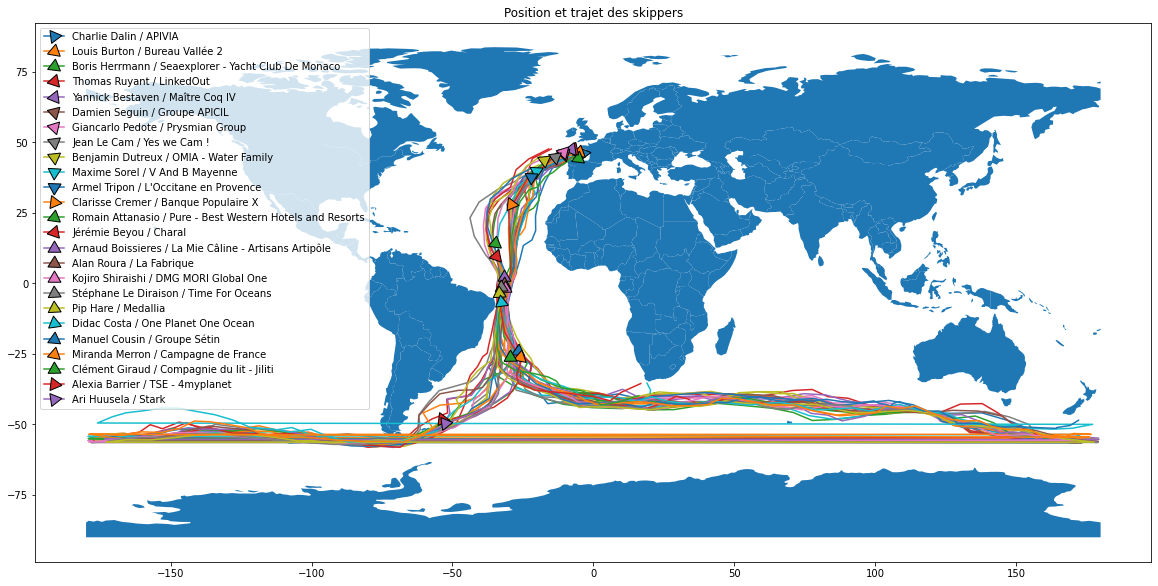

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.plot(ax=ax)

# Affichage des trajectoires
for skipper in hist['Skipper/Bateau'].unique():
    tab = hist.loc[(hist['Skipper/Bateau'] == skipper)]
    plt.plot(tab['Longitude'], tab['Latitude'])

# Remise à zéro du cycle de couleurs de matplotlib
plt.gca().set_prop_cycle(None)

# Affichage de la position actuelle des bateaux
for index, row in df_end.iterrows():
    ax.plot(
        row['Longitude'], 
        row['Latitude'], 
        marker=(3,0, float(row['Cap'])), 
        markersize=15, 
        markeredgewidth=1,
        markeredgecolor='black',
        label=row['Skipper/Bateau'])

ax.legend(loc='upper left')
plt.title('Position et trajet des skippers')
plt.show()


In [13]:
top_10 = df_end['Skipper/Bateau'][:10]

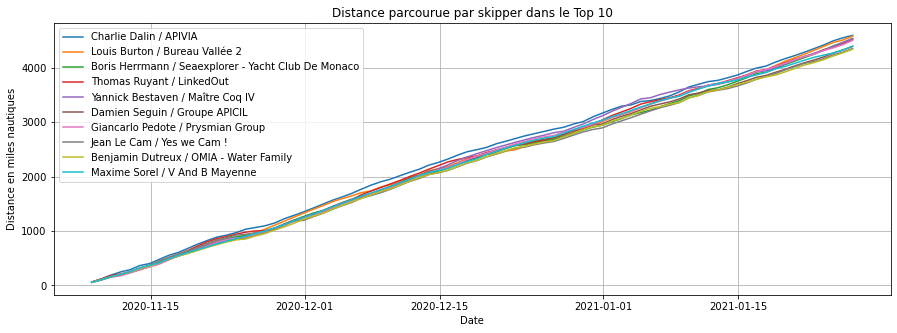

In [14]:
plt.figure(figsize=(15, 5))
for skipper in top_10:
    tab = hist.loc[hist['Skipper/Bateau'] == skipper]
    tab = tab.loc[tab['Distance'] < 1000]
    plt.plot(tab.iloc[:]['date'], tab['Distance'].cumsum(), label=skipper)

plt.grid(True, 'both', 'both')
plt.title('Distance parcourue par skipper dans le Top 10')
plt.xlabel('Date')
plt.ylabel('Distance en miles nautiques')
plt.legend()
plt.show()

### Evolution du podium

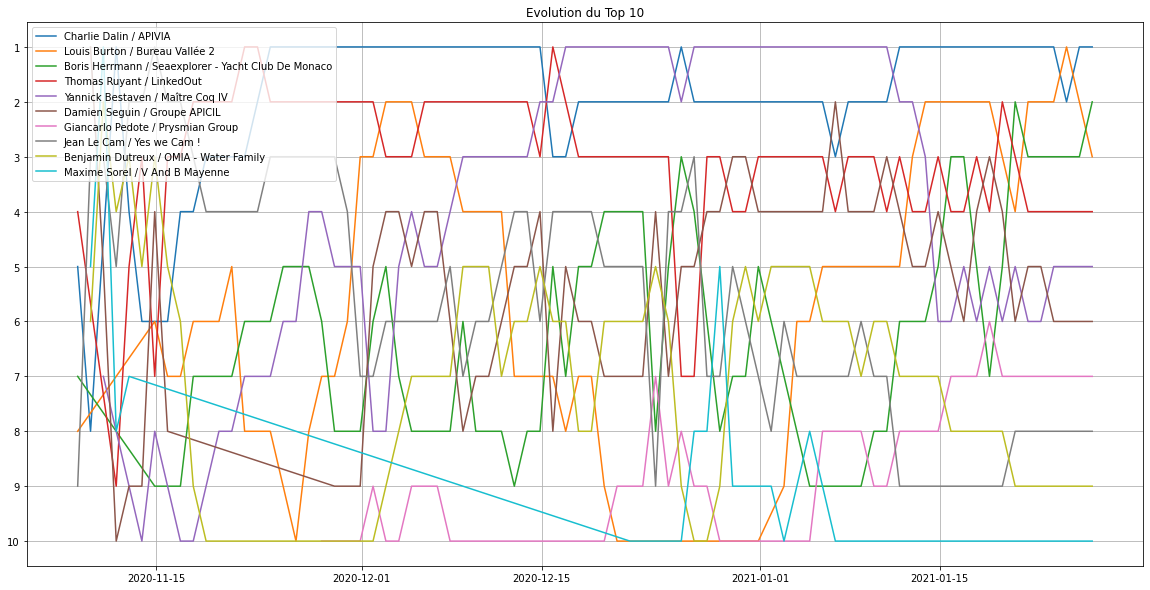

In [15]:
plt.figure(figsize=(20, 10))

for skipper in top_10:
    tab = hist.loc[(hist['Skipper/Bateau'] == skipper) & (hist['Rang'] <= 10)]
    if len(tab) > 0:
        plt.plot(tab['date'], tab['Rang'], label=skipper)

plt.gca().invert_yaxis()

plt.yticks(np.arange(1, 11, step=1))
plt.grid(True, 'major', 'both')
plt.legend(loc='upper left')
plt.title('Evolution du Top 10')

plt.show()

In [16]:
leader = df_end.iloc[0]['Skipper/Bateau']
print(leader + ' est actuellement en tête de la course.')

Charlie Dalin / APIVIA est actuellement en tête de la course.


#### Quelle est sa vitesse ?

On obtient un vitesse moyenne de 14,29 noeuds.

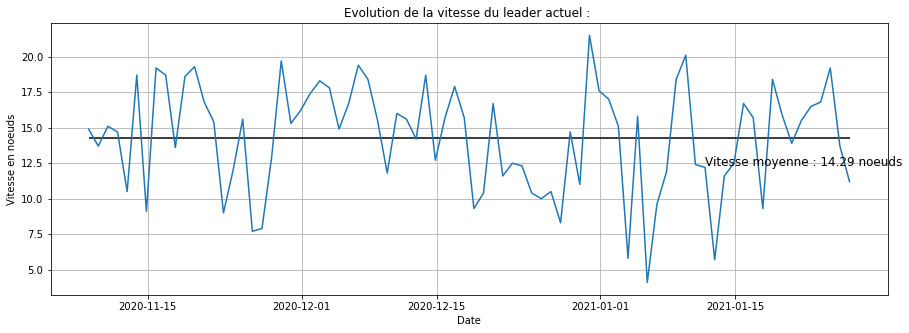

In [17]:
first = hist.loc[hist['Skipper/Bateau'] == leader]
plt.figure(figsize=(15, 5))
plt.plot(first['date'], first['Vitesse'].astype(float))
plt.hlines(first['Vitesse'].mean(), first['date'].min(), first['date'].max(), colors='black')
plt.text(
    x=first['date'].max()-datetime.timedelta(days=15), 
    y=first['Vitesse'].mean()-2, 
    s='Vitesse moyenne : {:.2f} noeuds'.format(first['Vitesse'].mean()),
    fontsize=12)
plt.grid(True, 'major', 'both')
plt.title('Evolution de la vitesse du leader actuel : ')
plt.xlabel('Date')
plt.ylabel('Vitesse en noeuds')
plt.show()

#### Quelle est son avance ?

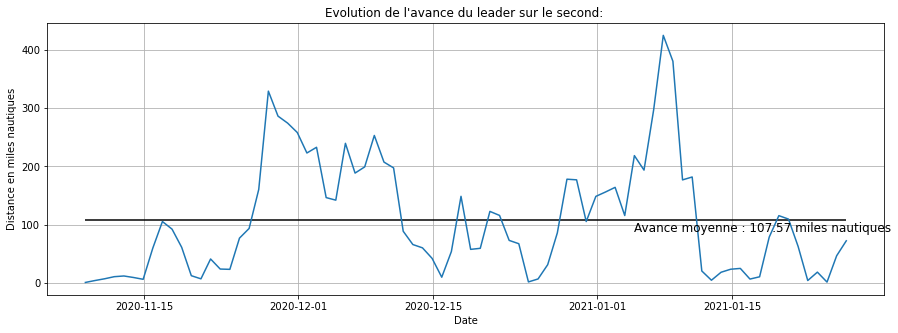

In [18]:
second = hist.loc[hist['Rang'] == 2]
plt.figure(figsize=(15, 5))
plt.plot(second['date'], second['DTL'].astype(float))
plt.hlines(second['DTL'].mean(), second['date'].min(), second['date'].max(), colors='black')
plt.text(
    x=second['date'].max()-datetime.timedelta(days=22), 
    y=second['DTL'].mean()-20, 
    s='Avance moyenne : {:.2f} miles nautiques'.format(second['DTL'].mean()),
    fontsize=12)
plt.grid(True, 'major', 'both')
plt.title('Evolution de l\'avance du leader sur le second: ')
plt.xlabel('Date')
plt.ylabel('Distance en miles nautiques')
plt.show()

## Comment expliquer ce classement ?

Afin d'obtenir des statistiques intéressantes sur chaque coureur, on calcule les moyennes de leurs différentes statistiques.

In [19]:
mean_df = hist.groupby('Skipper/Bateau').mean()
mean_df.head()

,Rang,Latitude,Longitude,Cap,Vitesse,VMG,Distance,DTF,DTL
Skipper/Bateau,,,,,,,,,
Alan Roura / La Fabrique,16.400000,-30.278508,-11.658946,132.237500,12.06125,10.83250,48.45625,13952.990000,1875.83000
Alex Thomson / HUGO BOSS,7.083333,-10.920299,-19.472049,156.291667,13.93750,11.55000,56.15000,20508.558333,361.92500
Alex Thomson / Hugo Boss,9.000000,45.468167,-6.998167,235.500000,12.75000,11.95000,53.95000,24100.750000,17.00000
Alexia Barrier / TSE - 4myplanet,25.150000,-28.513854,-4.755094,130.962500,10.69625,9.52500,42.97625,15756.027500,3678.86750
Ari Huusela / Stark,26.412500,-26.898635,-3.902356,126.300000,10.96625,9.38375,44.05500,15942.986250,3865.82125


### Corrélation VMG et classement


<div style="text-align: justify">   
En croisant les informations techniques des bateaux et celles du classement, on peut dégager des intuitions à propos des éléments favorables ou défavorables aux participants de la course.
Ci-dessous, on regarde la position moyenne de chaque participant sur la durée totale de la course (depuis le 1er jour jusqu'aujourd'hui), et on y associe la VMG moyenne sur la même période.
La VMG donne une indication entre la vitesse du bateau et l'angle du CAP. Un skipper qui voudra aller le plus rapidement d'un point A à un point B, devra trouver le meilleur compris entre l'angle de sa trajectoire pour rester au plus proche du vent, et sa vitesse en noeuds. Dans l'exemple ci-dessous, la VMG est maximisée pour une angle de 50°. Le bateau parcourt une distance plus grande, mais il a le compromis idéal entre distance et vitesse. Sa VMG est donc maximale (source https://www.orange-marine.com/content/474-bien-comprendre-le-principe-de-la-vmg-a-la-voile).
</div>

<div style="text-align: justify">
Finalement, effectuons une simple régression linéraire entre les valeurs de VMG en moyenne pour les participants, et leur position moyenne dans le classement.  
Les résultats ci-dessous permettent de distinguer clairement la __relation linéaire__ entre ces 2 variables. Plus la VMG est élevée, meilleure est la position dans le classement.  
Les pentes des droites de régression donnent un résultat interressant, puisqu'on voit que, si les bateaux équipés de foil ont tendance à avoir une VMG plus élevée que les autres, ces derniers, lorsqu'ils atteignent des valeurs de VMG suffisamment grande, ont tendance à obtenir de meilleures positions.
</div>

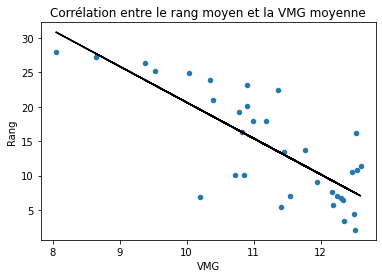

In [20]:
regr = linear_model.LinearRegression().fit(np.array(mean_df['VMG']).reshape(-1, 1), mean_df['Rang'])

mean_df.plot.scatter(x = 'VMG', y = 'Rang')
plt.plot(mean_df['VMG'], regr.predict(np.array(mean_df['VMG']).reshape(-1, 1)), color='black')
plt.title('Corrélation entre le rang moyen et la VMG moyenne')
plt.show()

In [21]:
np.corrcoef(mean_df['VMG'], mean_df['Rang'])[0][1]

-0.7822428959679929

### Quelles caractéristiques des bateaux peuvent influer sur sa vitesse ?

Nous essayons de déterminer si des caractéristiques spécifiques des voiliers influent positivement ou négativement sur la VMG d'un voilier. 

Pour cela, récupérons quelques caractéristiques des voiliers depuis le site du Vendée Globe.

In [22]:
def get_boats_specs():
    df = pd.DataFrame()

    soup = get_soup('https://www.vendeeglobe.org/fr/glossaire')
    boat_list = soup.find_all('div', {'class': 'boats-list__popup-infos'})

    for boat in boat_list:
        temp_df = pd.DataFrame()
        temp_df['Nom'] = pd.Series(boat.find('h3').text)
        for li in boat.find('ul').find_all('li'):
            spec = li.text.split(' : ')
            temp_df[spec[0]] = pd.Series(spec[1])
        df = pd.concat([df, temp_df])

    # Retrait des unités et conversion en valeurs numériques
    for col in ['Longueur', 'Largeur', 'Tirant d\'eau', 'Déplacement (poids)', 'Hauteur mât', 'Surface de voiles au près', 'Surface de voiles au portant']:
        df[col] = df[col].apply(lambda x: re.sub(' ?[A-Za-z]+[2²]?', '', x).replace(',', '.')).astype(float, errors='ignore')
    
    return df

boat = get_boats_specs()
boat

,Nom,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,Déplacement (poids),Nombre de dérives,Hauteur mât,Voile quille,Surface de voiles au près,Surface de voiles au portant
0,NEWREST - ART & FENÊTRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,18.28,5.85,4.5,7,foils,29.0,monotype,320.0,570.0
0,PURE - Best Western®,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,18.28,5.80,4.5,9,2,28.0,acier forgé,280.0,560.0
0,TSE - 4MYPLANET,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,18.28,5.54,4.5,9,2,29.0,acier,260.0,580.0
0,Maître CoQ IV,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,18.28,5.80,4.5,8,foils,29.0,acier mécano soudé,310.0,550.0
0,CHARAL,08,NaN,VPLP,CDK Technologies,18 Août 2018,18.28,5.85,4.5,8,foils,29.0,acier,320.0,600.0
0,LA MIE CÂLINE - ARTISANS ARTIPÔLE,FRA 14,"Ecover3, Président, Gamesa, Kilcullen Voyager-...",Owen Clarke Design LLP - Clay Oliver,Hakes Marine - Mer Agitée,03 Août 2007,18.28,5.65,4.5,7.9,foils,29.0,basculante avec vérin,300.0,610.0
0,BUREAU VALLEE 2,18,Banque Populaire VIII,Verdier - VPLP,CDK Technologies,09 Juin 2015,18.28,5.80,4.5,7.6,foils,28.0,acier,300.0,600.0
0,ONE PLANET ONE OCEAN,ESP 33,Kingfisher - Educacion sin Fronteras - Forum M...,Owen Clarke Design,Martens Yachts,02 Février 2000,18.28,5.30,4.5,8.9,2,26.0,acier,240.0,470.0
0,GROUPE SÉTIN,FRA 71,"Paprec-Virbac2, Estrella Damm, We are Water, L...",Bruce Farr Yacht Design,Southern Ocean Marine (Nouvelle-Zélande),02 Février 2007,18.28,5.80,4.5,9,2 asymétriques,28.5,basculante sur vérin hydraulique,270.0,560.0
0,BANQUE POPULAIRE X,FRA30,Macif - SMA,Verdier - VPLP,CDK - Mer Agitée,01 Mars 2011,18.28,5.70,4.5,7.7,2,29.0,acier forgé,340.0,570.0


Combinons les données de caractéristiques des voiliers aux données de statistiques moyennes de la course.

In [23]:
merge_mean_df = mean_df.copy().reset_index()
merge_mean_df['Jointure'] = merge_mean_df['Skipper/Bateau'].apply(lambda x: x.split(' / ')[1].lower())
merge_boat_df = get_boats_specs()
merge_boat_df['Nom'] = merge_boat_df['Nom'].str.lower()

specs_df = pd.merge(
    left=merge_mean_df,
    right=merge_boat_df,
    left_on='Jointure',
    right_on='Nom',
    how='left'
).drop(columns=['Nom', 'Jointure'])

#### Importance des foils

Les _foils_ sont des appendices attachés à la coque d'un voilier. Prenant généralement le profil d'une aile d'avion, les foils fournissent de la portance au voilier, lui permettant de 'décoller' de la surface de l'eau au delà d'une certaine vitesse. Cela permet de grandement réduire la traînée générée par le frottement du voilier avec l'eau.

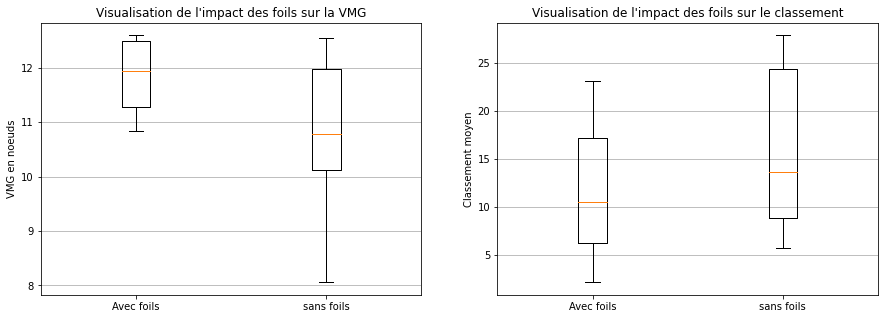

In [24]:
with_foils = specs_df.loc[specs_df['Nombre de dérives'] == 'foils']
without_foils = specs_df.loc[specs_df['Nombre de dérives'] != 'foils']

fig, ax = plt.subplots(1,2, figsize=(15, 5))
ax[0].boxplot([with_foils['VMG'].astype(float), without_foils['VMG'].astype(float)], labels=['Avec foils', 'sans foils'])
ax[0].title.set_text('Visualisation de l\'impact des foils sur la VMG')
ax[0].set_ylabel('VMG en noeuds')
ax[1].boxplot([with_foils['Rang'].astype(float), without_foils['Rang'].astype(float)], labels=['Avec foils', 'sans foils'])
ax[1].title.set_text('Visualisation de l\'impact des foils sur le classement')
ax[1].set_ylabel('Classement moyen')
for a in ax:
    a.grid(True, 'both', 'y')
fig.show()

In [25]:
print('{} voiliers sur {}, soit {:.1f} % sont équipés de foils.'.format(len(with_foils), len(specs_df), len(with_foils)*100/len(specs_df)))

15 voiliers sur 34, soit 44.1 % sont équipés de foils.


On remarque que la distribution des voiliers équipés de foils ont une plus grande vitesse que ceux qui n'en sont pas équipés, et tendent à être plus haut dans le classement. Cependant, même s'ils constituent un avantage, on remarque que les foils sont présent sur toute l'étendue du classement.

#### Autres caractéristiques

Ayant déterminé que la présence de foils joue un rôle important sur la vitesse et donc le classement, essayons de déterminer si d'autres caractéristiques des bateaux ont de l'importance. On s'intéresse ici aux caractéristiques numériques.

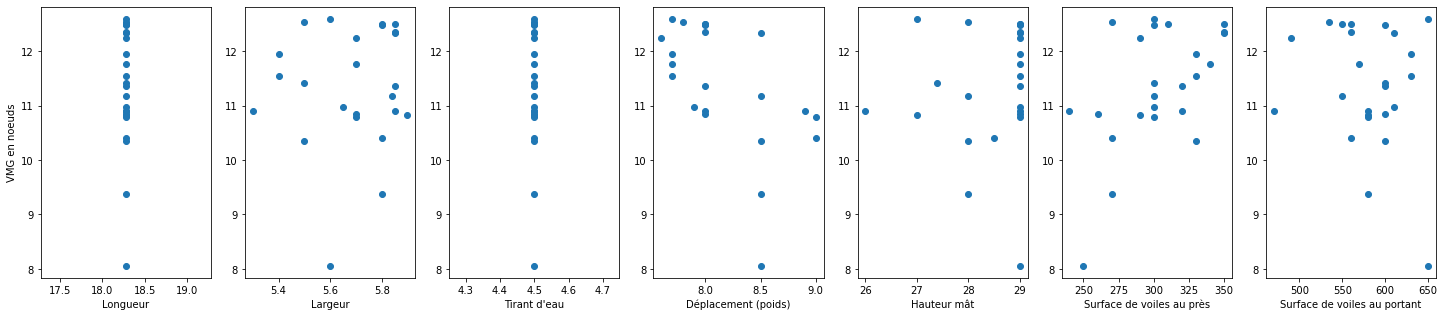

In [26]:
fig, ax = plt.subplots(1, 7, figsize=(25,5))

cols = [
    'Longueur', 
    'Largeur', 
    'Tirant d\'eau', 
    'Déplacement (poids)', 
    'Hauteur mât', 
    'Surface de voiles au près', 
    'Surface de voiles au portant']
for i in range(len(ax)):
    tmp = specs_df[['VMG', cols[i]]].loc[specs_df[cols[i]] != '']
    ax[i].scatter(tmp[cols[i]].astype(float), tmp['VMG'].astype(float))
    ax[i].set_xlabel(cols[i])

ax[0].set_ylabel('VMG en noeuds')

fig.show()

On ne décèle sur ces graphiques aucune corrélation entre la VMG et les caractéristiques numériques des bateaux. On peut donc en conclure que, d'après les caractéristiques que nous connaissons de notre jeu de données, la présence de foils est celle qui a le plus d'impact sur la vitesse, et donc le classement du skipper.